## Import Libraries

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

2025-07-14 08:20:35.409490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752481235.624172      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752481235.678511      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Image Paths

In [ ]:
train_images = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/*/*.jpeg')
test_images = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/test/*/*.jpeg')
val_images = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/val/*/*.jpeg')

In [ ]:
print(len(train_images))
print(len(test_images))
print(len(val_images))

5216
624
16


In [ ]:
train_labels = [img_path.split('/')[-2] for img_path in train_images]
test_labels = [img_path.split('/')[-2] for img_path in test_images]
val_labels = [img_path.split('/')[-2] for img_path in val_images]

In [ ]:
print(len(train_labels))
print(len(test_labels))
print(len(val_labels))

5216
624
16


## Read & Preprocess Images

In [ ]:
def preprocess_images(images, labels, img_size=(128, 128)):
    preprocess_images = []
    for img in tqdm(images, desc='processing..'):
        image = cv2.imread(img)
        image = cv2.resize(image, img_size)
        image = image / 255.0
        preprocess_images.append(image)
    return np.array(preprocess_images), np.array(labels)

In [ ]:
X_train, y_train = preprocess_images(train_images, train_labels)
X_test, y_test = preprocess_images(test_images, test_labels)
X_val, y_val = preprocess_images(val_images, val_labels)

processing..: 100%|██████████| 16/16 [00:00<00:00, 74.65it/s]


In [ ]:
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')
print(f'X_val Shape: {X_val.shape}')
print(f'y_val Shape: {y_val.shape}')

X_train Shape: (5216, 128, 128, 3)
y_train Shape: (5216,)
X_test Shape: (624, 128, 128, 3)
y_test Shape: (624,)
X_val Shape: (16, 128, 128, 3)
y_val Shape: (16,)


## Data Visualization

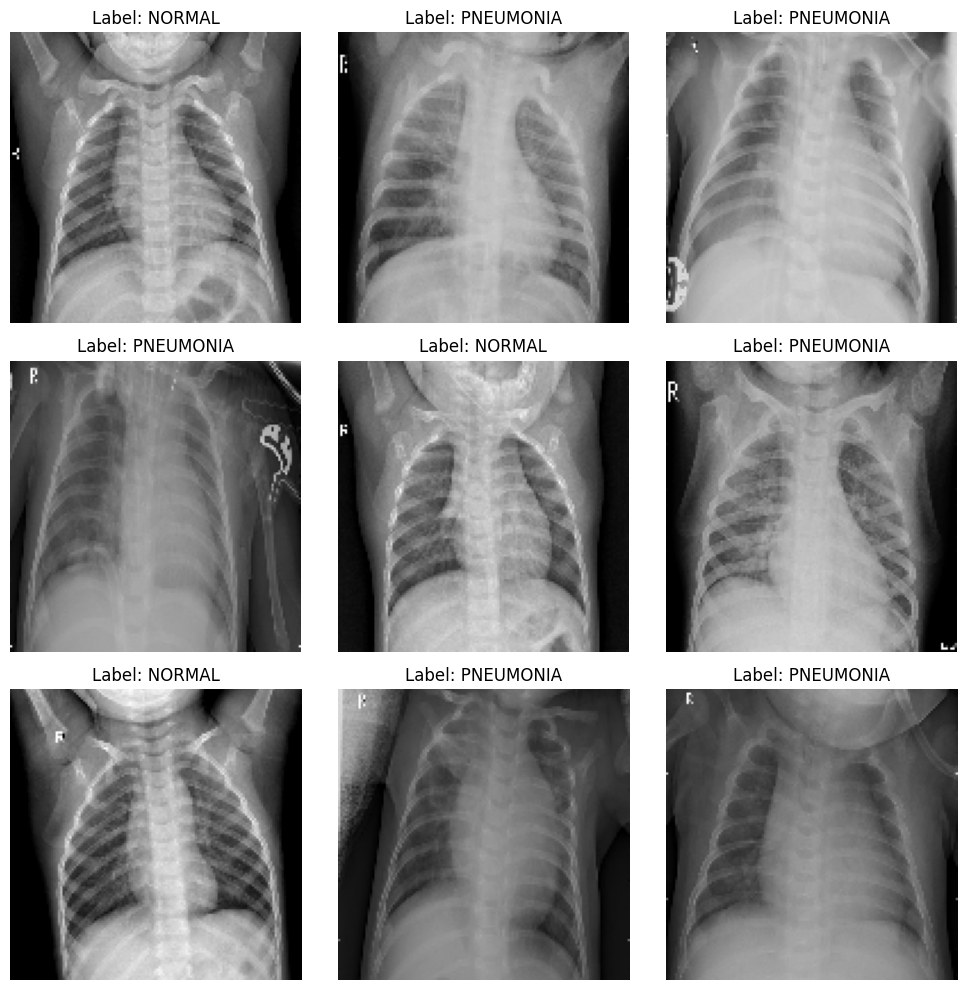

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, X_train.shape[0])
        img = X_train[idx]
        label = y_train[idx]
        axs[i, j].imshow(img)
        axs[i, j].set_title(f'Label: {label}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

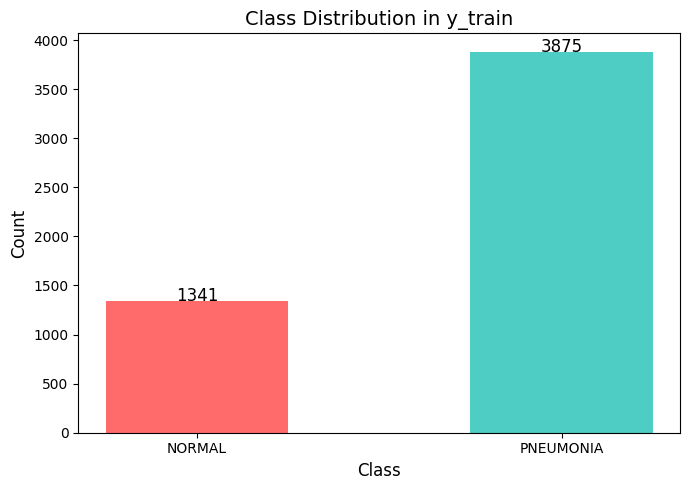

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(7, 5))
bars = plt.bar(unique, counts, color=['#FF6B6B', '#4ECDC4'], width=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=12)

plt.title('Class Distribution in y_train', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

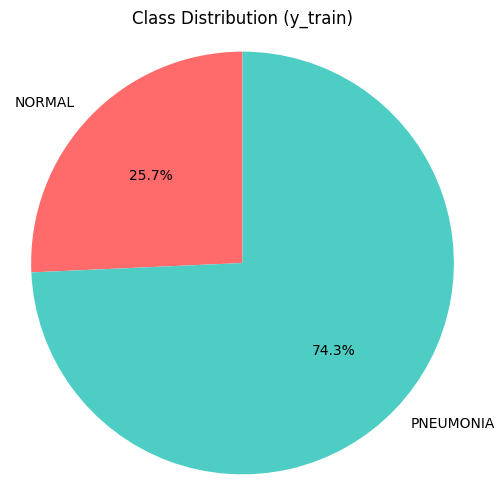

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4'])
plt.title('Class Distribution (y_train)')
plt.axis('equal')
plt.show()

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_val = label_encoder.fit_transform(y_val)

In [ ]:
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

## Data Augmentation & Class Balance

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f'Class {label}: {count} samples')

Class 0: 1349 samples
Class 1: 3883 samples


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True,
    seed=42
)

## Buliding & Training Model

In [ ]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D((4, 4)),

    Conv2D(128, (3, 3)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D((4, 4)),

    Flatten(),
    Dense(16),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        18,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,713 (436.38 KB)

 Trainable params: 111,713 (436.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.939214232765011, 1: 0.6737058975019315}


In [ ]:
history = model.fit(train_generator, epochs=30, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.5212 - loss: 0.6588 - val_accuracy: 0.8205 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.8508 - loss: 0.3318 - val_accuracy: 0.8285 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8838 - loss: 0.2692 - val_accuracy: 0.8734 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9018 - loss: 0.2329 - val_accuracy: 0.9103 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9229 - loss: 0.1933 - val_accuracy: 0.8670 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9220 - loss: 0.1846 - val_accuracy: 0.8974 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9

## Model Evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print('Test accuracy:', acc)
print('Test loss:', loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9413 - loss: 0.1510
Test accuracy: 0.9230769276618958
Test loss: 0.23520377278327942


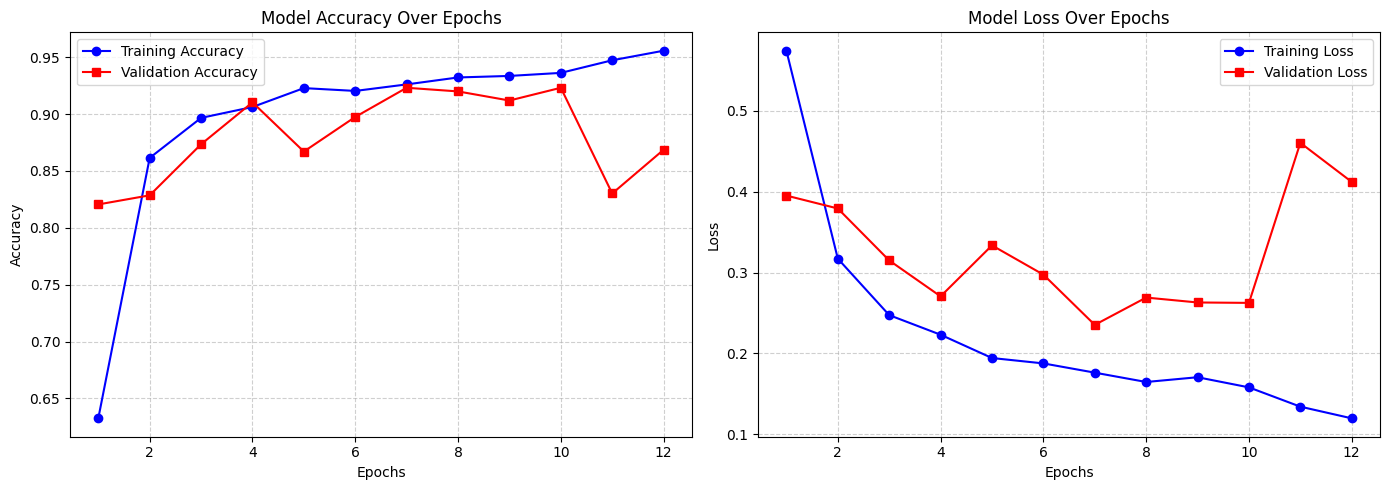

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



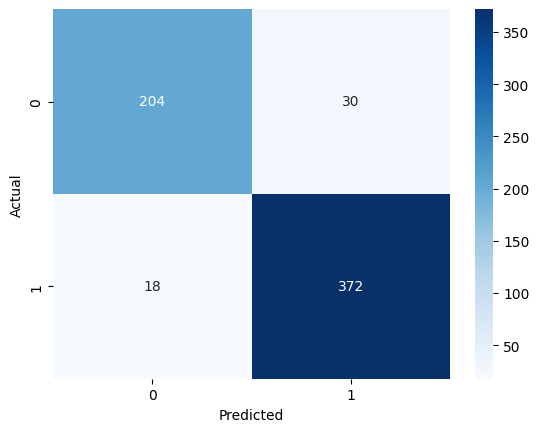

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()